This is the code that goes with the K-means clustering series of posts:

- [Part 1: Overview and choice of K](http://www.salientiastuff.com/k-means-clustering-part-1.html)
- [Part 2: Initialization Techniques](http://www.salientiastuff.com/k-means-clustering-part-2.html)
- Part 3 (in progress)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from matplotlib import gridspec
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.decomposition.pca import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

### Contents

The contents of this notebook appear in roughly the same order as the corresponding figures in the blog posts.

- Part 0: Preliminaries
   + Initialization Functions
   + Post-Initialization Functions
- Part 1: Overview
   + Blob Data
   + Digits Data
   + Iris Data
- Part 2: Different Initializations
   + Random Partition
   + Random Points
   + K-means++
   + Comparing Initializations

### Part 0: Preliminaries

Here we define the functions we'll need later on to perform K-means clustering.

#### Initialization Functions

Functions with which to initialize the cluster labels or centroids:

- The random partition method randomly assigns each data point to a cluster.
- Random points initialization picks $K$ points, uniformly at random, to be the initial centroids.
- K-means++ successively chooses data points to be initial centroids, where the probability that a point will be chosen as a centroid is proportional to the square of its distance to the nearest existing centroid.

In [2]:
def initialize_clusters(dataframe, number_of_clusters):
    '''
    Initialize the cluster labels using the random partition method which
    randomly assigns each data point to a cluster.
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    cluster_labels : numpy array
        an array of cluster labels
    '''
    # Randomly assign cluster labels
    cluster_labels = np.random.choice(range(number_of_clusters), size = len(dataframe))
    
    # Check whether the number of resulting clusters matches the desired number
    actual_cluster_count = len(set(cluster_labels))
    if (actual_cluster_count < number_of_clusters):
        warning_msg = ('Random initialization yielded {} clusters instead of the desired {}.'
                       .format(actual_cluster_count, number_of_clusters))
        warnings.warn(warning_msg)
        
    return cluster_labels

In [3]:
def initialize_centroids_random_points(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the random points initialization method  
    of choosing data points uniformly at random.
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    centroids : pandas DataFrame
        a dataframe consisting of the points chosen to be the centroids
    '''
    # Randomly sample centroids from the data
    indices = np.random.choice(dataframe.index, size = number_of_clusters, replace = False)
    
    # Build dataframe of centroids
    centroids = dataframe.loc[indices, :]
    centroids.index = range(number_of_clusters)
    
    return centroids

In [4]:
def initialize_centroids_plusplus_with_densities(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the K-Means++ initialization method
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    (centroids, densities) : (pandas DataFrame, dict)
        a dataframe consisting of the points chosen to be the centroids
    '''
    data_points = len(dataframe)
    indices = []
    densities = {}
    
    # Initialize inverted distances to max
    distances = np.array([np.infty for i in range(data_points)])
    # Start with uniform distribution across data
    prob_distribution = np.array([1/data_points for i in range(data_points)])
    
    for i in range(number_of_clusters):
        densities[i] = prob_distribution
        index = int(np.random.choice(range(data_points), size = 1, p = prob_distribution))
        indices.append(index)
        centroid = dataframe.iloc[index]
        
        # Compute inverted distances to centroid
        new_distances = ((dataframe - centroid)
                         .apply(lambda x: x**2)
                         .sum(axis = 1))
        distances = np.minimum(distances, new_distances)
        prob_distribution = (distances/sum(distances)).values

    # Build dataframe of centroids
    centroids = dataframe.loc[indices, :]
    centroids.index = range(number_of_clusters)

    return (centroids, densities)

def initialize_centroids_plusplus(dataframe, number_of_clusters):
    '''
    Initialize the cluster centroids using the K-Means++ initialization method
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data which is going to be clustered
        
    number_of_clusters : int 
        the number of centroids to initialize (i.e. the desired number of clusters)
        
    Returns
    -------
    centroids : pandas DataFrame
        a dataframe consisting of the points chosen to be the centroids
    '''
    return initialize_centroids_plusplus_with_densities(dataframe, number_of_clusters)[0]

#### Post-Initialization Functions

Functions for carrying out K-means:

- a function to compute cluster centroids given the cluster labels
- a function to compute the cluster labels given the cluster centroids
- a function to compute the within-cluster variance (the objective we're minimizing)

In [5]:
def compute_centroid(data, clusters):
    '''
    Given the data and cluster labels, computes and returns the cluster centroids
    
    Parameters
    ----------
    data : pandas DataFrame 
        numerical data
        
    clusters : numpy array 
        an array of cluster labels, one for each row of data
        
    Returns
    -------
    centroids : pandas DataFrame
        a dataframe consisting of the cluster centroids
    '''
    df = data.copy()
    df['cluster'] = clusters
    centroids = df.groupby('cluster').mean()
    return centroids

In [6]:
def single_row_cluster_label(row, centroids):
    '''
    Takes a row of data (corresponding to a single data point) and 
    returns the label of the nearest centroid
    
    Parameters
    ----------
    row : row from a pandas DataFrame 
        a single row of data
        
    centroids : pandas DataFrame 
        dataframe consisting of the current cluster centroids
        
    Returns
    -------
    label : int
        the label of the nearest centroid
    '''
    label = ((row - centroids)
                   .apply(lambda x: x**2)
                   .sum(axis = 1)
                   .argmin())
    return label

def get_cluster_labels(dataframe, centroids):
    '''
    Computes the cluster label assignments for each row in the
    dataframe using the given centroids.
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data
        
    centroids : pandas DataFrame 
        dataframe consisting of the current cluster centroids
        
    Returns
    -------
    labels : numpy array
        the cluster labels for the data
    '''
    labels = dataframe.apply(single_row_cluster_label, 
                             centroids = centroids, 
                             axis = 1)
    return labels

In [7]:
def compute_objective(data, centroids, labels):
    '''
    Computes and returns the within-cluster variation for the
    data using the given centroids and labels
    
    Parameters
    ----------
    dataframe : pandas DataFrame 
        numerical data
        
    centroids : pandas DataFrame 
        dataframe consisting of the current cluster centroids
        
    labels : numpy array 
        the cluster labels
        
    Returns
    -------
    objective : float
        the within-cluster variation
    '''
    objective = 0
    for i in centroids.index.values:
        objective += ((data[labels == i] - centroids.loc[i])
                          .apply(lambda x: x**2)
                          .values.sum())
    return objective

### Part 1: Overview

In this part, we build or load the various data sets that we'll use and examine the results of K-means clustering on some of them.

#### Blob Data

Create some 2-dimensional toy data sets with differing variance (corresponding to better or worse separated clusters). We'll mostly work with X1.

In [8]:
# Build toy data sets with 4 clusters each, and different variances
X1, y1 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 0.5, random_state = 0)
X2, y2 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 0.75, random_state = 0)
X3, y3 = datasets.make_blobs(n_samples = 200, n_features = 2, centers = 4, cluster_std = 1.0, random_state = 0)

X1_df = pd.DataFrame(X1, columns = ['x', 'y'])
X2_df = pd.DataFrame(X2, columns = ['x', 'y'])
X3_df = pd.DataFrame(X3, columns = ['x', 'y'])
X1_df.head()

,x,y
0,2.204387,1.560857
1,-1.133740,2.684673
2,1.064983,4.102897
3,-2.376038,7.324207
4,1.682890,0.484444


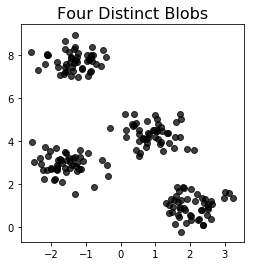

In [9]:
# Plot X1
fig = plt.figure(figsize = [4, 4])
plt.scatter(X1[:, 0], X1[:, 1], c = 'black', alpha = 0.75)
plt.title('Four Distinct Blobs', fontsize = 16)
# plt.savefig('four_blobs.png', bbox_inches='tight')
plt.show()

#### Digits Data

Load and examine the handwritten digits data.

In [10]:
digits = datasets.load_digits()
digits_data = digits.data
digits_data.shape

(1797, 64)

Each example is represented as an 8x8 array of pixel intensities, measured on a scale from 0 to 16.

In [11]:
# First data point
digits_data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

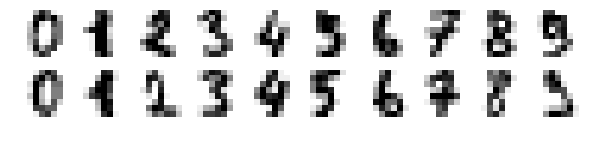

In [12]:
plt.figure(figsize = [10, 2])
for i in range(20):
    plt.subplot(2, 10, i + 1)
    plt.axis('off')
    plt.imshow(digits.images[i], cmap=plt.cm.gray_r, interpolation='nearest')
# plt.savefig('example_digits.png', bbox_inches='tight')
plt.show()

We can perform K-means clustering on this data with K = 3 and see which digits end up in which cluster.

In [13]:
# Perform K-means on digits data with K = 3
digit_kmeans = KMeans(n_clusters = 3, random_state = 0).fit(digits_data)
digit_labels = digit_kmeans.labels_

In [14]:
clustered_digits_df = pd.DataFrame({'cluster':digit_labels, 'digit':digits.target})
pd.crosstab(clustered_digits_df.cluster, clustered_digits_df.digit)

digit,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,2,38,161,167,0,72,1,0,65,146
1,0,140,16,16,55,97,1,179,108,34
2,176,4,0,0,126,13,179,0,1,0


We can also visualize this by looking at sample images in each cluster...

In [15]:
# Randomly select samples from each of the 3 clusters
np.random.seed(0)
samples = 16
class_1 = np.random.choice(np.where(digit_labels == 0)[0], size = samples, replace = False)
class_2 = np.random.choice(np.where(digit_labels == 1)[0], size = samples, replace = False)
class_3 = np.random.choice(np.where(digit_labels == 2)[0], size = samples, replace = False)

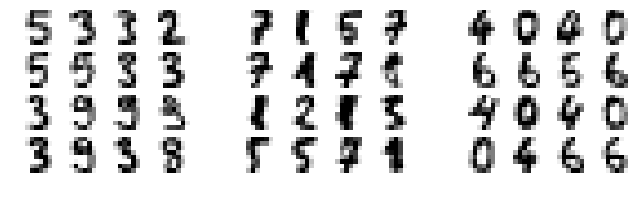

In [16]:
plt.figure(figsize = [11, 3])
for i in range(min(16, len(class_1))):
    plt.subplot(4, 14, 1 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_1[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    
for i in range(min(16, len(class_2))):
    plt.subplot(4, 14, 6 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_2[i]], cmap=plt.cm.gray_r, interpolation='nearest')
    
for i in range(min(16, len(class_3))):
    plt.subplot(4, 14, 11 + (i//4)*14 + i%4)
    plt.axis('off')
    plt.imshow(digits.images[class_3[i]], cmap=plt.cm.gray_r, interpolation='nearest')

# plt.savefig('digit_clusters.png', bbox_inches='tight')
plt.show()

...Or by plotting the full data set using principal component analysis.

In [17]:
# Represent digits data using the first 2 principal components
digit_pca = PCA(n_components = 2).fit_transform(digits_data)

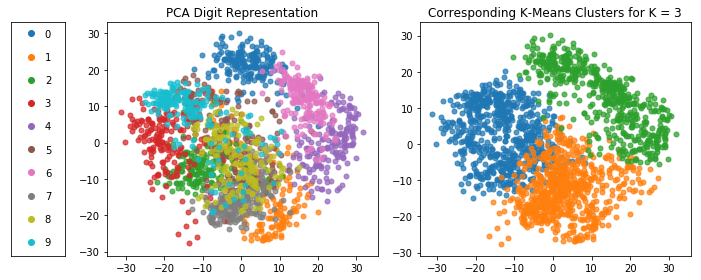

In [18]:
# Plot the data using PCA, first with the digit labels, 
# then with the cluster labels
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 5, 5]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis = 'both', which = 'both', 
                bottom = 'off', top = 'off', left = 'off', right = 'off',
                labelbottom = 'off', labelleft = 'off')

for i in range(10):
    ax0.scatter([0], [10 - i])
    ax0.scatter([0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([-0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([1.0], [10 - i], alpha = 0, c = 'white')
    ax0.text(0.5, 10 - i - 0.15, i)

ax1 = plt.subplot(gs[1])
plt.title('PCA Digit Representation')
for i in range(10):
    points = digit_pca[digits.target == i]
    ax1.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)
    
ax2 = plt.subplot(gs[2])
plt.title('Corresponding K-Means Clusters for K = 3')
for i in range(3):
    points = digit_pca[digit_labels == i]
    ax2.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)

plt.tight_layout()
# plt.savefig('digits_pca.png', bbox_inches='tight')
plt.show()

To get a better understanding of these groupings, let's look at the first few principal components.

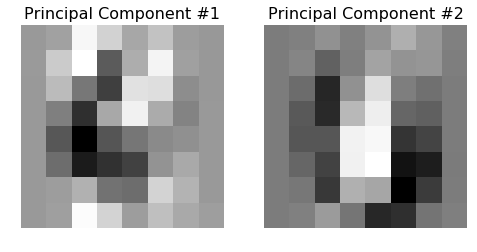

In [19]:
# Represent the principal components as grayscale images
n_pca_components = 2
pca_components = PCA(n_components = n_pca_components).fit(digits_data)

fig = plt.figure(figsize = [4*n_pca_components, 4])

for i in range(n_pca_components):
    plt.subplot(1, n_pca_components, 1 + i)
    plt.title('Principal Component #{}'.format(1 + i), fontsize = 16)
    plt.axis('off')
    plt.imshow(pca_components.components_[i].reshape(8, 8), cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

In [20]:
# Compute T-SNE representation of digits (this can take some time)
digit_tsne = TSNE(random_state = 0).fit_transform(digits_data)

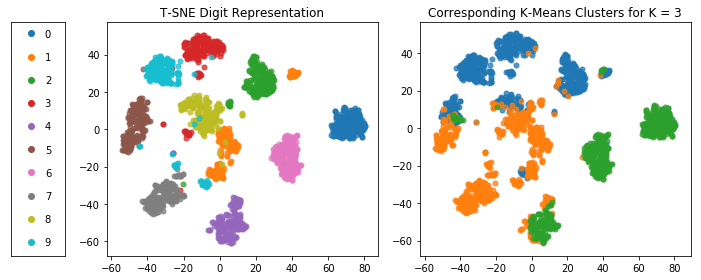

In [21]:
fig = plt.figure(figsize=(10, 4)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 5, 5]) 
ax0 = plt.subplot(gs[0])
ax0.tick_params(axis = 'both', which = 'both', 
                bottom = 'off', top = 'off', left = 'off', right = 'off',
                labelbottom = 'off', labelleft = 'off')

for i in range(10):
    ax0.scatter([0], [10 - i])
    ax0.scatter([0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([-0.5], [10 - i], alpha = 0, c = 'white')
    ax0.scatter([1.0], [10 - i], alpha = 0, c = 'white')
    ax0.text(0.5, 10 - i - 0.15, i)

ax1 = plt.subplot(gs[1])
plt.title('T-SNE Digit Representation')
for i in range(10):
    points = digit_tsne[digits.target == i]
    ax1.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)
    
ax2 = plt.subplot(gs[2])
plt.title('Corresponding K-Means Clusters for K = 3')
for i in range(3):
    points = digit_tsne[digit_labels == i]
    ax2.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 25)

plt.tight_layout()
# plt.savefig('digits_tsne.png', bbox_inches='tight')
plt.show()

#### Iris Data

In [22]:
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris.data, columns = iris.feature_names)

iris_data_full = iris_data.copy()
iris_data_full['species'] = iris.target_names[iris.target]

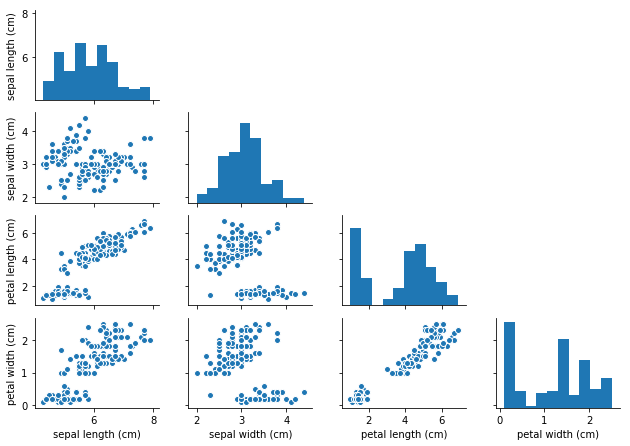

In [23]:
g = sns.pairplot(iris_data_full)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

g.fig.set_size_inches([9, 6])
# g.savefig('iris_pairplot_unlabeled.png', bbox_inches='tight')

plt.show()

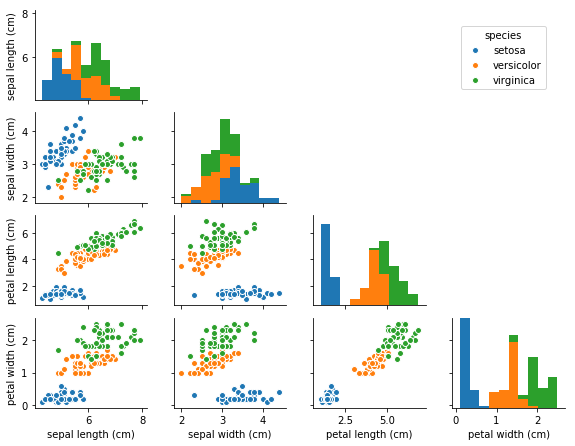

In [24]:
g = sns.pairplot(iris_data_full, hue = 'species')
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)

g.fig.set_size_inches([9, 6], )
leg = g.fig.get_children()[-1]
leg.set_bbox_to_anchor((0.85, 0.9, 0, 0))
#leg.set_frame_on(False)

# g.savefig('iris_pairplot_labeled.png', bbox_inches='tight')

plt.show()

In [25]:
# Represent data using first 2 principal components
iris_pca = PCA(n_components = 2).fit_transform(iris_data)

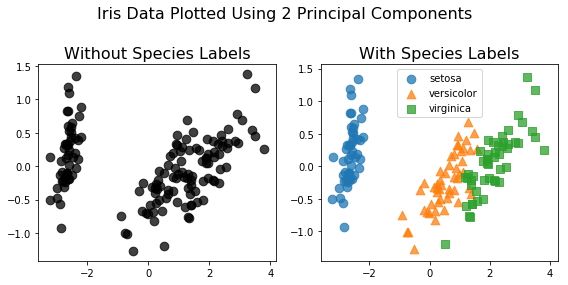

In [26]:
fig = plt.figure(figsize = [8,4])
fig.suptitle("Iris Data Plotted Using 2 Principal Components", fontsize = 16)

# Plot unlabeled irises
plt.subplot(1, 2, 1)
plt.title('\n\nWithout Species Labels', fontsize = 16)
plt.scatter(iris_pca[:, 0], iris_pca[:, 1], color = 'black', alpha = 0.75, s = 75)

# Label the different species
plt.subplot(1, 2, 2)
plt.title('\n\nWith Species Labels', fontsize = 16)
marker_list = ['o', '^', 's']
for index, species in enumerate(iris.target_names):
    points = iris_pca[iris.target == index]
    plt.scatter(points[:, 0], points[:, 1], label = species, marker = marker_list[index], alpha = 0.75, s = 75)

plt.legend(loc = 9)
plt.tight_layout()

# plt.savefig('iris_PCA.png', bbox_inches='tight')
plt.show()

In [27]:
# Run K-means with K = 2, 3
iris_kmeans_2 = KMeans(n_clusters = 2, random_state = 0).fit(iris_data)
iris_kmeans_3 = KMeans(n_clusters = 3, random_state = 0).fit(iris_data)

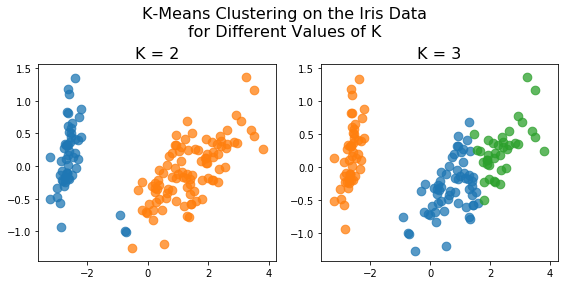

In [28]:
fig = plt.figure(figsize = [8, 4])

plt.subplot(1, 2, 1)
plt.title("\n\nK = 2", fontsize = 16)
for i in range(2):
    points = iris_pca[iris_kmeans_2.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 75)
    
plt.subplot(1, 2, 2)
plt.title("\n\nK = 3", fontsize = 16)
for i in range(3):
    points = iris_pca[iris_kmeans_3.labels_ == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75, s = 75)
    
plt.suptitle('K-Means Clustering on the Iris Data\nfor Different Values of K', fontsize = 16)
plt.tight_layout()

# plt.savefig('iris_clustering.png', bbox_inches='tight')

plt.show()

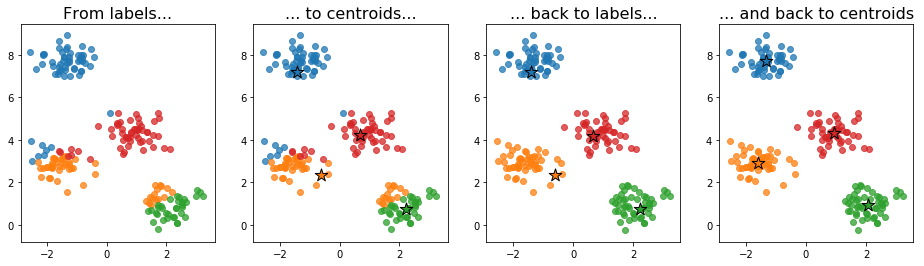

In [29]:
np.random.seed(0)
initial_centroids = initialize_centroids_random_points(X1_df, 4)
initial_labels = get_cluster_labels(X1_df, initial_centroids)
new_centroids = compute_centroid(data = X1_df, clusters = initial_labels)
new_labels = get_cluster_labels(X1_df, new_centroids)
newer_centroids = compute_centroid(data = X1_df, clusters = new_labels)
newer_labels = get_cluster_labels(X1_df, newer_centroids)

fig = plt.figure(figsize = [16, 4])

plt.subplot(1, 4, 1)
plt.title('From labels...', fontsize = 16)

for i in initial_centroids.index.values:
    points = X1[initial_labels == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.subplot(1, 4, 2)
plt.title('... to centroids...', fontsize = 16)

for i in initial_centroids.index.values:
    points = X1[initial_labels == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(new_centroids.loc[i][0], new_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')
    
plt.subplot(1, 4, 3)
plt.title('... back to labels...', fontsize = 16)

for i in new_labels.index.values:
    points = X1[new_labels == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(new_centroids.loc[i][0], new_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')
    
plt.subplot(1, 4, 4)
plt.title('... and back to centroids', fontsize = 16)

for i in new_labels.index.values:
    points = X1[new_labels == i]
    plt.scatter(points[:, 0], points[:, 1], alpha = 0.75)
    
plt.gca().set_prop_cycle(None)

for i in initial_centroids.index.values:
    plt.scatter(newer_centroids.loc[i][0], newer_centroids.loc[i][1], marker = '*', s = 175, edgecolors = 'black')

# plt.savefig('clustering_process.png', bbox_inches='tight')
plt.show()

### Part 2: Different Initializations

#### Random Partition

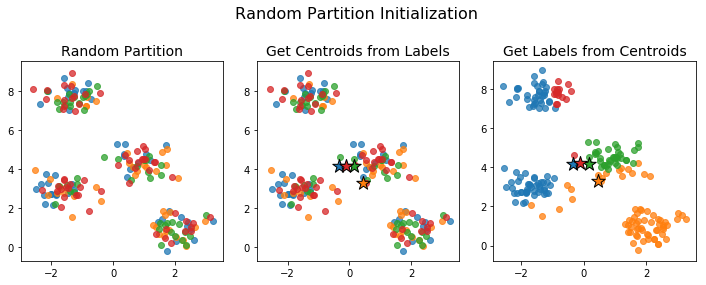

In [35]:
np.random.seed(0)
initial_clusters = initialize_clusters(X1_df, 4)


fig = plt.figure(figsize = [10, 4])
plt.suptitle('Random Partition Initialization', fontsize = 16)

plt.subplot(1, 3, 1)
plt.title('\n\nRandom Partition', fontsize = 14)
for i in range(4):
    points = X1_df[initial_clusters == i]
    plt.scatter(points.x, points.y, alpha = 0.75)

centroids = compute_centroid(X1_df, initial_clusters)

plt.subplot(1, 3, 2)
plt.title('\n\nGet Centroids from Labels', fontsize = 14)
for i in range(4):
    points = X1_df[initial_clusters == i]
    plt.scatter(points.x, points.y, alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in range(4):
    plt.scatter(centroids.x[i], centroids.y[i], s = 200, marker = '*', edgecolor = 'black')
    
new_labels = get_cluster_labels(X1_df, centroids)
plt.subplot(1, 3, 3)
plt.title('\n\nGet Labels from Centroids', fontsize = 14)
for i in range(4):
    points = X1_df[new_labels == i]
    plt.scatter(points.x, points.y, alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in range(4):
    plt.scatter(centroids.x[i], centroids.y[i], s = 200, marker = '*', edgecolor = 'black')

plt.tight_layout()
# plt.savefig('random_partition_initialization.png', bbox_inches='tight')
plt.show()

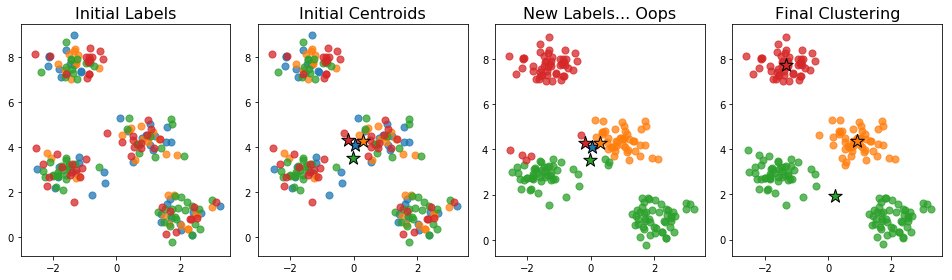

In [36]:
fig = plt.figure(figsize = [10*4/3, 4])

np.random.seed(31)
initial_labels = initialize_clusters(X1_df, 4)

plt.subplot(1, 4, 1)
plt.title('Initial Labels', fontsize = 16)
for i in range(4):
    points = X1_df[initial_labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)
    
centroids = compute_centroid(X1_df, initial_labels)

plt.subplot(1, 4, 2)
plt.title('Initial Centroids', fontsize = 16)
for i in range(4):
    points = X1_df[initial_labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)
plt.gca().set_prop_cycle(None)
for i in range(4):
    plt.scatter(centroids.x[i], centroids.y[i], s = 200, marker = '*', edgecolor = 'black')

old_objective = compute_objective(X1_df, centroids, initial_labels)

labels = get_cluster_labels(X1_df, centroids)
plt.subplot(1, 4, 3)
plt.title('New Labels... Oops', fontsize = 16)
for i in range(4):
    points = X1_df[labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)

plt.gca().set_prop_cycle(None)
    
for i in range(4):
    points = centroids[centroids.index == i]
    plt.scatter(points.x, points.y, s = 200, marker = '*', edgecolor = 'black')

while True:
    labels = get_cluster_labels(X1_df, centroids)
    centroids = compute_centroid(X1_df, labels)
    new_objective = compute_objective(X1_df, centroids, labels)
    if new_objective == old_objective:
        break
    else:
        old_objective = new_objective        

plt.subplot(1, 4, 4)
plt.title('Final Clustering', fontsize = 16)
for i in range(4):
    points = X1_df[labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)

plt.gca().set_prop_cycle(None)
    
for i in range(4):
    points = centroids[centroids.index == i]
    plt.scatter(points.x, points.y, s = 200, marker = '*', edgecolor = 'black')

plt.tight_layout()

# plt.savefig('bad_random_partition.png', bbox_inches='tight')
plt.show()

The code below simulates an example where the random partition initialization method leads to many empty clusters early on. Ten clusters of equal size are concentrated along the x-axis at the odd integers -9, -7, ..., 7, 9. Randomly assigning labels should yield centroids near 0, sandwiching many of them in such a way as to not be the nearest centroid to any point.

In [32]:
# build clusters of 100 points each centered at the odd integers from -9 to 9
n_clusters = 10 # should be even
cluster_size = 100
cluster_means = [c for c in range(-n_clusters, n_clusters) if c%2 == 1]
x_coordinates = (np.repeat(cluster_means, repeats=cluster_size) 
                 + np.random.normal(scale=0.1, size=n_clusters*cluster_size))

# randomly assign each point a label
labels = np.random.choice(range(10), size=n_clusters*cluster_size)

# combine into a dataframe and compute the cluster centroids
# (in this case, just the mean x-coordinates)
df = pd.DataFrame({'start_label':labels, 'x':x_coordinates})
centroid_df = df.groupby('start_label').mean()

# sort the centroids and compare to data values
initial_centroids = centroid_df.sort_values('x').values.flatten()
max_negative_x = max([x for x in x_coordinates if x < 0])
min_positive_x = min([x for x in x_coordinates if x >= 0])

# Get upper bound on number of clusters
max_centroids = 2 # corresponding to max an min values
max_centroids += sum(initial_centroids <= max_negative_x)
max_centroids += sum(initial_centroids >= min_positive_x)

print('Initial Centroids: {}'.format(initial_centroids))
print('\nData: x < {:.3} or {:.3} < x'.format(max_negative_x, min_positive_x))
print('\nMax Clusters: {}'.format(max_centroids))

Initial Centroids: [-0.74687296 -0.58791496 -0.37044886 -0.18774911 -0.06438459 -0.03555715
  0.17784778  0.36424602  0.4953837   0.88830221]

Data: x < -0.696 or 0.776 < x

Max Clusters: 4


The code below simulates the edge case where the number of clusters is large relative to the total number of data points. In this case, there is a non-negligible probability that at least one cluster does not have any data points assigned to it.

In [39]:
# Set number of data points and clusters
datapoints = 1000
clusters = 200

# Perform a large number of trials
trials = 100000
success = 0
for i in range(trials):
    # Randomly assign labels
    assignments = np.random.choice(range(clusters), 
                                   replace = True, 
                                   size = datapoints)
    # Check whether all labels are present
    if len(np.unique(assignments)) == clusters:
        success += 1

# Print frequency of successful trials
print(success/trials)

0.2568


The code below computes the true probability that no cluster is initially empty using some combinatorics.

In [40]:
# import binomial coefficient
from scipy.special import binom as n_choose_k

datapoints = 1000
clusters = 200

# Compute the probability that a given k clusters/labels are missing
def p_missing(k, datapoints, clusters):
    return ((clusters - k)/clusters)**(datapoints)

# Use inclusion-exclusion to compute the probability that no cluster is empty
sum([(-1)**(k)*n_choose_k(clusters, k)*p_missing(k, datapoints, clusters)for k in range(clusters)])

0.257130136778871

#### Random Points

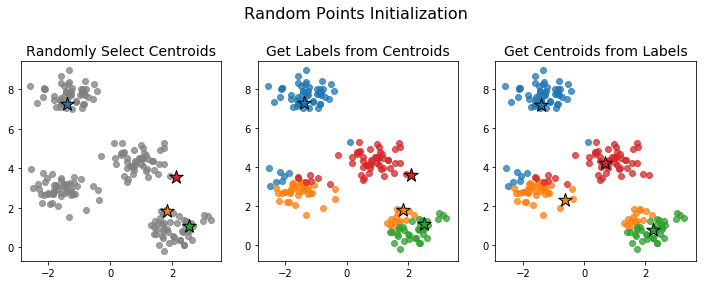

In [37]:
np.random.seed(0)
initial_centroids = initialize_centroids_random_points(X1_df, 4)

fig = plt.figure(figsize = [10, 4])
plt.suptitle('Random Points Initialization', fontsize = 16)

plt.subplot(1, 3, 1)
plt.title('\n\nRandomly Select Centroids', fontsize = 14)
plt.scatter(X1_df.x, X1_df.y, alpha = 0.75, color = 'gray')

for i in range(4):
    plt.scatter(initial_centroids.x[i], initial_centroids.y[i], marker = '*', s = 200, edgecolor = 'black')

cluster_labels = get_cluster_labels(X1_df, initial_centroids)

plt.subplot(1, 3, 2)
plt.title('\n\nGet Labels from Centroids', fontsize = 14)
for i in range(4):
    points = X1_df[cluster_labels == i]
    plt.scatter(points.x, points.y, alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in range(4):
    plt.scatter(initial_centroids.x[i], initial_centroids.y[i], s = 200, marker = '*', edgecolor = 'black')
    
new_centroids = compute_centroid(X1_df, cluster_labels)
plt.subplot(1, 3, 3)
plt.title('\n\nGet Centroids from Labels', fontsize = 14)
for i in range(4):
    points = X1_df[cluster_labels == i]
    plt.scatter(points.x, points.y, alpha = 0.75)

plt.gca().set_prop_cycle(None)

for i in range(4):
    plt.scatter(new_centroids.x[i], new_centroids.y[i], s = 200, marker = '*', edgecolor = 'black')

plt.tight_layout()
# plt.savefig('random_points_initialization.png', bbox_inches='tight')
plt.show()

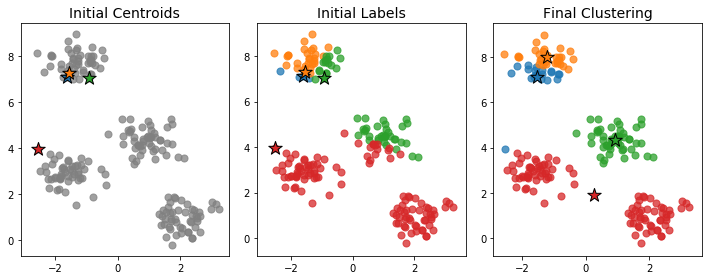

In [38]:
fig = plt.figure(figsize = [10, 4])

np.random.seed(27)
initial_centroids = initialize_centroids_random_points(X1_df, 4)

plt.subplot(1, 3, 1)
plt.title('Initial Centroids', fontsize = 14)
plt.scatter(X1_df.x, X1_df.y, s = 50, alpha = 0.75, color = 'gray')
for i in range(4):
    plt.scatter(initial_centroids.x[i], initial_centroids.y[i], s = 200, marker = '*', edgecolor = 'black')

labels = get_cluster_labels(X1_df, initial_centroids)

plt.subplot(1, 3, 2)
plt.title('Initial Labels', fontsize = 14)
for i in range(4):
    points = X1_df[labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)
plt.gca().set_prop_cycle(None)
for i in range(4):
    plt.scatter(initial_centroids.x[i], initial_centroids.y[i], s = 200, marker = '*', edgecolor = 'black')

old_objective = compute_objective(X1_df, initial_centroids, labels)

while True:
    centroids = compute_centroid(X1_df, labels)
    labels = get_cluster_labels(X1_df, centroids)
    new_objective = compute_objective(X1_df, centroids, labels)
    if new_objective == old_objective:
        break
    else:
        old_objective = new_objective        

plt.subplot(1, 3, 3)
plt.title('Final Clustering', fontsize = 14)
for i in range(4):
    points = X1_df[labels == i]
    plt.scatter(points.x, points.y, s = 50, alpha = 0.75)

plt.gca().set_prop_cycle(None)
    
for i in range(4):
    points = centroids[centroids.index == i]
    plt.scatter(points.x, points.y, s = 200, marker = '*', edgecolor = 'black')

plt.tight_layout()

# plt.savefig('bad_random_points.png', bbox_inches='tight')
plt.show()

#### K-Means++

In [35]:
# Build smaller data set to show off K-means++ initialization
X4, y4 = datasets.make_blobs(n_samples = 20, n_features = 2, centers = 4, cluster_std = 0.4, random_state = 0)
X4_df = pd.DataFrame({'x': X4[:, 0], 'y':X4[:, 1]})

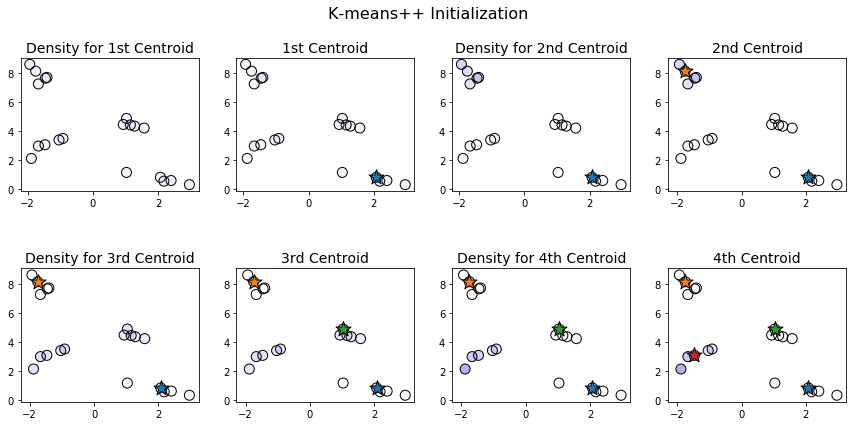

In [46]:
np.random.seed(0)
centroids, densities = initialize_centroids_plusplus_with_densities(X4_df, 4)

color_dict = {j: [(0.0, 0.0, 0.75, a*1) for a in densities[j]] for j in range(4)}
index_dict = {0: '1st', 1: '2nd', 2: '3rd', 3: '4th'}

fig = plt.figure(figsize = [12,6])
fig.suptitle('K-means++ Initialization', fontsize = 16)

for c in range(4):
    # Plot Centroid Probability Density
    plt.subplot(2, 4, c*2 + 1)
    plt.title('\n\nDensity for {} Centroid'.format(index_dict[c]), fontsize = 14)
    plt.scatter(X4[:, 0], X4[:, 1], color = color_dict[c], s = 100, edgecolors = 'black')

    for i in range(c):
        plt.scatter(centroids.x[i], centroids.y[i], marker = '*', s = 250, edgecolors = 'black')

    # Add Centroid
    plt.subplot(2, 4, c*2 + 2)
    plt.title('\n\n{} Centroid'.format(index_dict[c]), fontsize = 14)
    plt.scatter(X4[:, 0], X4[:, 1], color = color_dict[c], s = 100, edgecolors = 'black')

    for i in range(c + 1):
        plt.scatter(centroids.x[i], centroids.y[i], marker = '*', s = 250, edgecolors = 'black')

plt.tight_layout()

# plt.savefig('plus_plus_initialization.png', bbox_inches='tight')
plt.show()

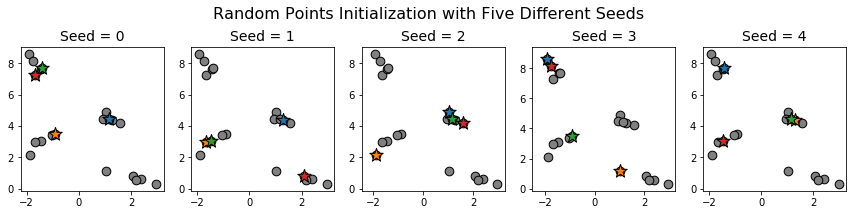

In [45]:
fig = plt.figure(figsize = [12,3])
plt.suptitle('Random Points Initialization with Five Different Seeds', fontsize = 16)
for i in range(5):
    np.random.seed(i)
    centroids_f = initialize_centroids_random_points(X4_df, 4)
    
    plt.subplot(1, 5, 1 + i)
    plt.title('\nSeed = {}'.format(i), fontsize = 14)
    
    plt.scatter(X4[:, 0], X4[:, 1], color = 'gray', s = 75, edgecolors = 'black')
    for j in range(4):
        plt.scatter(centroids_f.x[j], centroids_f.y[j], marker = '*', s = 200, edgecolors = 'black')
        
plt.tight_layout()
# plt.savefig('five_random_points.png', bbox_inches='tight')
plt.show()

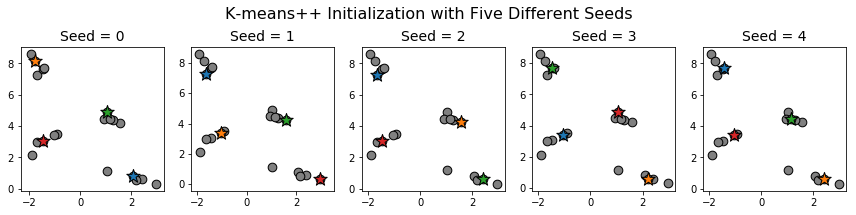

In [44]:
fig = plt.figure(figsize = [12,3])
plt.suptitle('K-means++ Initialization with Five Different Seeds', fontsize = 16)
for i in range(5):
    np.random.seed(i)
    centroids_p = initialize_centroids_plusplus(X4_df, 4)
    
    plt.subplot(1, 5, 1 + i)
    plt.title('\nSeed = {}'.format(i), fontsize = 14)
    
    plt.scatter(X4[:, 0], X4[:, 1], color = 'gray', s = 75, edgecolors = 'black')
    for j in range(4):
        plt.scatter(centroids_p.x[j], centroids_p.y[j], marker = '*', s = 200, edgecolors = 'black')
        
plt.tight_layout()
# plt.savefig('five_kplusplus.png', bbox_inches='tight')
plt.show()

#### Comparing Initializations

For each initialization method, run K-means clustering for 100 different intializations.

In [39]:
%%time
# %%timeit # for a more rigorous timing comparison

random_partition_steps = []
random_partition_objective = []

for i in range(100):
    np.random.seed(i)
    steps = 0
    initial_labels = initialize_clusters(X1_df, 4)
    centroids = compute_centroid(X1_df, initial_labels)
    old_objective = compute_objective(X1_df, centroids, initial_labels)
    while True:
        # Update labels
        labels = get_cluster_labels(X1_df, centroids)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
        
        # Update centroids
        centroids = compute_centroid(X1_df, labels)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
            
    random_partition_steps.append(steps)
    random_partition_objective.append(new_objective)

Wall time: 2min 9s


In [40]:
%%time
# %%timeit # for a more rigorous timing comparison

random_points_steps = []
random_points_objective = []

for i in range(100):
    np.random.seed(i)
    steps = 0
    initial_centroids = initialize_centroids_random_points(X1_df, 4)
    labels = get_cluster_labels(X1_df, initial_centroids)
    old_objective = compute_objective(X1_df, initial_centroids, labels)
    while True:
        # Update centroids
        centroids = compute_centroid(X1_df, labels)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
        
        # Update labels
        labels = get_cluster_labels(X1_df, centroids)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
            
    random_points_steps.append(steps)
    random_points_objective.append(new_objective)

Wall time: 2min 30s


In [41]:
%%time
# %%timeit # for a more rigorous timing comparison

kplusplus_steps = []
kplusplus_objective = []

for i in range(100):
    np.random.seed(i)
    steps = 0
    initial_centroids = initialize_centroids_plusplus(X1_df, 4)
    labels = get_cluster_labels(X1_df, initial_centroids)
    old_objective = compute_objective(X1_df, initial_centroids, labels)
    while True:
        # Update centroids
        centroids = compute_centroid(X1_df, labels)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
        
        # Update labels
        labels = get_cluster_labels(X1_df, centroids)
        new_objective = compute_objective(X1_df, centroids, labels)
        if new_objective == old_objective:
            break
        else:
            steps += 1
            old_objective = new_objective
            
    kplusplus_steps.append(steps)
    kplusplus_objective.append(new_objective)

Wall time: 1min 37s


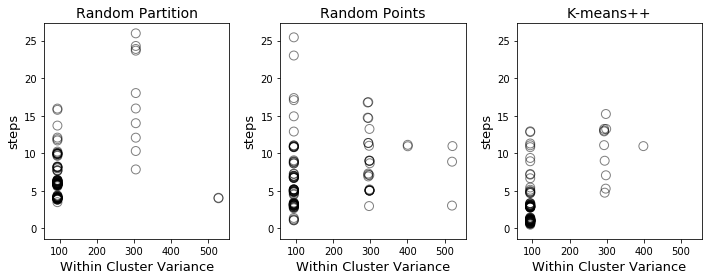

In [43]:
np.random.seed(0)
vnoise = np.random.normal(scale = 0.2, size = 100)
fig = plt.figure(figsize = [10, 4])

ax1 = plt.subplot(1, 3, 1)
plt.title('Random Partition', fontsize = 14)
plt.scatter(random_partition_objective, random_partition_steps + vnoise, 
            alpha = 0.50, s = 80, facecolor = 'none', edgecolor = 'black')
plt.xlabel('Within Cluster Variance', fontsize = 13)
plt.ylabel('steps', fontsize = 13)

ax2 = plt.subplot(1, 3, 2, sharex = ax1, sharey = ax1)
plt.title('Random Points', fontsize = 14)
plt.scatter(random_points_objective, random_points_steps + vnoise, 
            alpha = 0.50, s = 80, facecolor = 'none', edgecolor = 'black')
plt.xlabel('Within Cluster Variance', fontsize = 13)
plt.ylabel('steps', fontsize = 13)

ax3 = plt.subplot(1, 3, 3, sharex = ax1, sharey = ax1)
plt.title('K-means++', fontsize = 14)
plt.scatter(kplusplus_objective, kplusplus_steps + vnoise,
            alpha = 0.50, s = 80, facecolor = 'none', edgecolor = 'black')
plt.xlabel('Within Cluster Variance', fontsize = 13)
plt.ylabel('steps', fontsize = 13)

plt.tight_layout()

# plt.savefig('initialization_comparisons.png', bbox_inches='tight')
plt.show()